## Gatys Style Transfer 论文复现

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

检测设备信息

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

先定义VGG网络。我们只需要用到前面的卷积层，用来提取图片的特征。
`avg_pool`参数表示是否用平均池化代替最大池化。

In [3]:
class FeatureExtractor(nn.Module):
    def __init__(self, avg_pool=True):
        super().__init__()
        # content on conv4_2
        # style on conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
        self.select = [0, 5, 10, 19, 28, 21]
        self.vgg = models.vgg19(weights=True).features[:29]  # pretrained
        for param in self.vgg.parameters():
            param.requires_grad_(False)
        if avg_pool:
            for i, layer in enumerate(self.vgg):
                if isinstance(layer, nn.MaxPool2d):
                    self.vgg[i] = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        features = dict()
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            if i in self.select:
                features[i] = x
        return features

之后就可以使用这个网络
```python
model = FeatureExtractor().to(device).eval()
```

In [4]:
model = FeatureExtractor().to(device).eval()
model.vgg

c:\Program Files\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (19): Conv2d(256

接下来读取图片

In [5]:
def image_loader(
        image_path,
        transform=None,
        device=torch.device("cpu"),
):
    """
    read an image
    process it to tensor available for vgg
    """
    image = Image.open(image_path)
    if transform:
        image = transform(image).unsqueeze(0)
    return image.to(device, torch.float)


image_size = 728 if device == torch.device("cuda") else 128

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.485, 0.456, 0.406),
        (0.229, 0.224, 0.225),
    ),
    # transforms.Lambda(lambda x: x[torch.LongTensor([2, 1, 0])]),
    # through experiment, RGB order is correct, no need to reverse
    transforms.Lambda(lambda x: x.mul(255)),  # 似乎是因为vgg训练时是用0-255的RGB图像
])

img_path = './img/'
save_path = './results/'
content_name = 'Tuebingen_Neckarfront'
style_name = 'vangogh_cut'  # 星月夜，裁剪掉了前面的树（因为风格迁移的时候会出现黑色块）
content_path = f'{img_path}{content_name}.jpg'
style_path = f'{img_path}{style_name}.jpg'

# load content and style image
content = image_loader(
    content_path,
    transform=transform,
    device=device
)
style = image_loader(
    style_path,
    transform=transform,
    device=device
)

再定义把图片转换回PIL格式的函数，并且显示图片

Text(0.5, 1.0, 'Style Image')

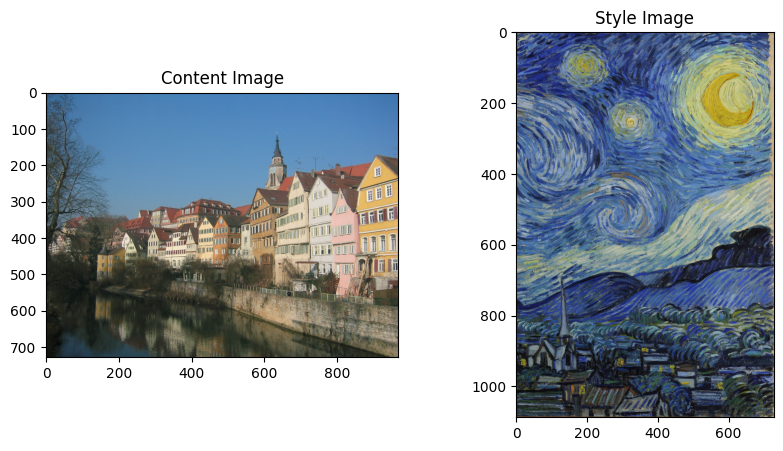

In [6]:
post_process = transforms.Compose([
    transforms.Lambda(lambda x: x.mul(1/255)),
    # transforms.Lambda(lambda x: x[torch.LongTensor([2, 1, 0])]),
    transforms.Normalize(
        (0, 0, 0),
        (1/0.229, 1/0.224, 1/0.225),
    ),
    transforms.Normalize(
        (-0.485, -0.456, -0.406),
        (1, 1, 1),
    ),
    transforms.Lambda(lambda x: x.clamp(0, 1)),
    transforms.ToPILImage(),
])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(post_process(content[0]))
plt.title('Content Image')

plt.subplot(1, 2, 2)
plt.imshow(post_process(style[0]))
plt.title('Style Image')

提取特征并计算Gram矩阵

In [7]:
def get_features(image, model):
    """
    get feature vectors
    """
    layers = model(image)
    features = dict()
    for key, value in layers.items():
        features[key] = value.reshape(value.shape[1], -1)
    return features


def gram_matrix(tensor):
    c, hw = tensor.size()
    gram = torch.mm(tensor, tensor.t())
    return gram / hw

得到`content`和`style`的特质

In [8]:
# get content and style features
content_feature = get_features(content, model)[21]
style_features = [get_features(style, model)[i] for i in [0, 5, 10, 19, 28]]
style_grams = [gram_matrix(feature) for feature in style_features]

In [9]:
content_feature

tensor([[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.8480],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [215.8073,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,  54.6342,   0.0000,   0.0000]],
       device='cuda:0')

In [10]:
style_features

[tensor([[  0.0000,   0.0000,   0.0000,  ...,  71.3181,  75.2284,  93.8495],
         [230.5498,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ..., 209.1719, 288.8246, 271.5610],
         ...,
         [ 15.4410,  57.9377,  73.8969,  ...,   0.0000,   0.0000,   0.0000],
         [161.6349, 270.1403, 257.9351,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],
        device='cuda:0'),
 tensor([[  0.0000,   0.0000,   0.0000,  ...,   0.0000,  70.7559,  86.9038],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [ 41.1236, 180.2421,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [220.8533,   0.0000,   0.0000,  ...,  90.8609, 291.0182,  39.2044]],
        device='cuda

采用随机初始化

In [11]:
# white noise image
target = torch.randn_like(content).mul(255).to(device).requires_grad_(True)

参数配置，来自[GitHub](https://github.com/leongatys/PytorchNeuralStyleTransfer/blob/master/NeuralStyleTransfer.ipynb)

In [12]:
content_weight = 1
style_weights = [1e3 / n**2 for n in [64, 128, 256, 512, 512]]
optimizer = optim.LBFGS([target])
steps = 300
show_every = 5

优化过程

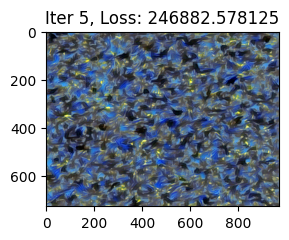

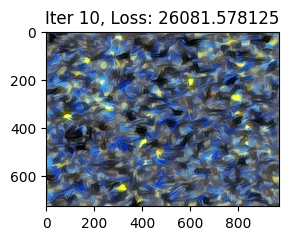

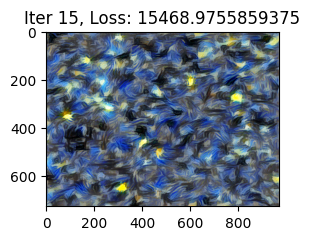

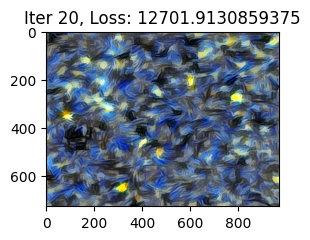

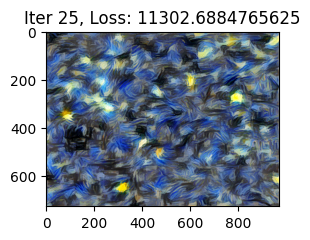

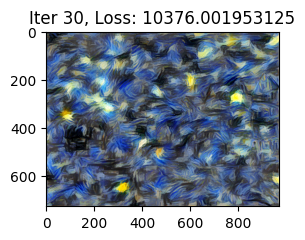

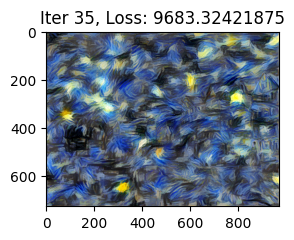

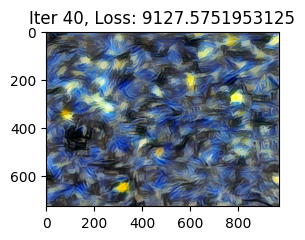

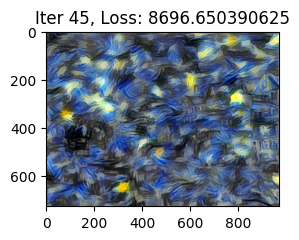

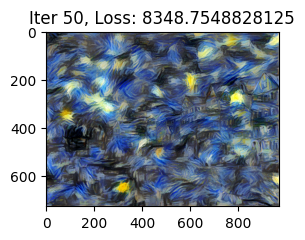

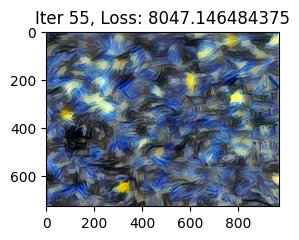

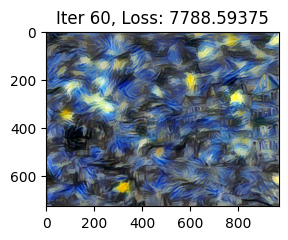

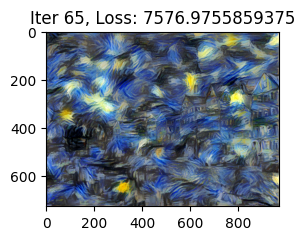

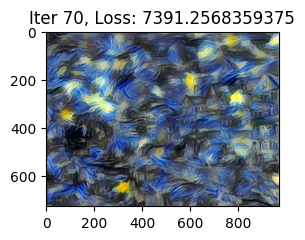

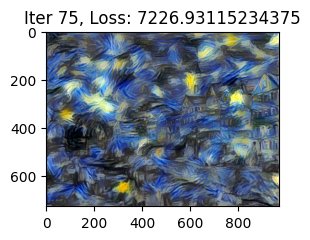

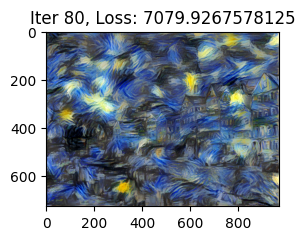

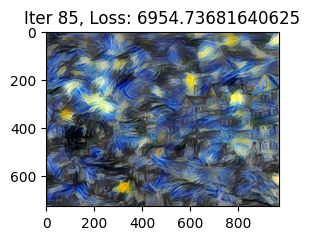

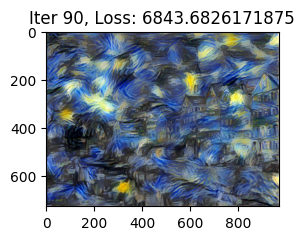

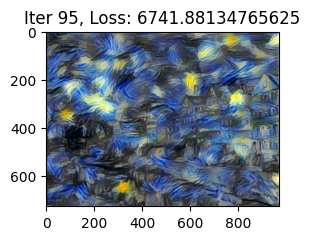

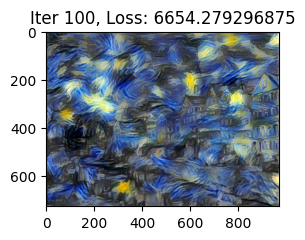

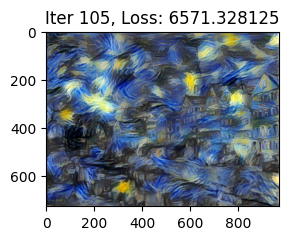

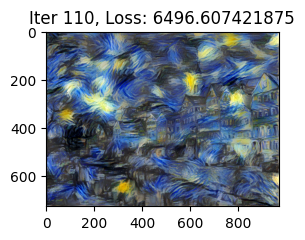

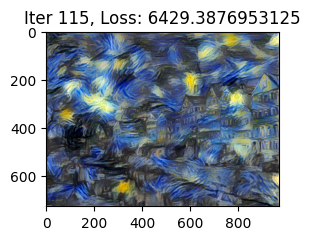

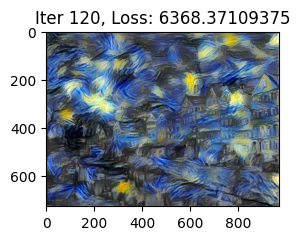

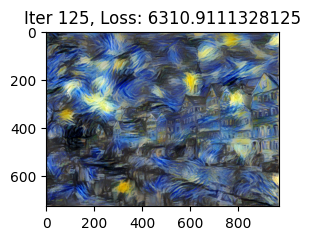

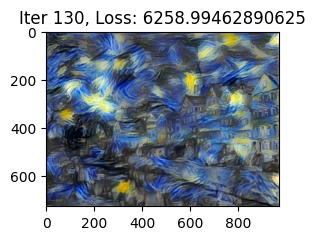

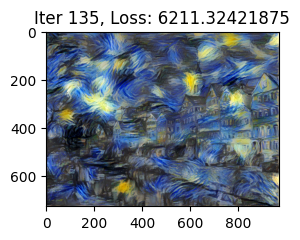

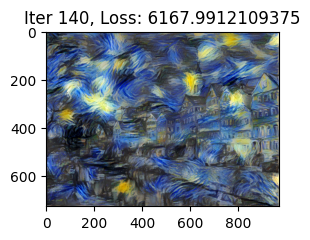

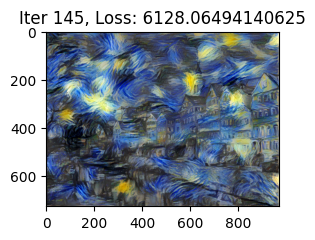

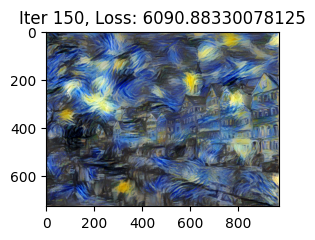

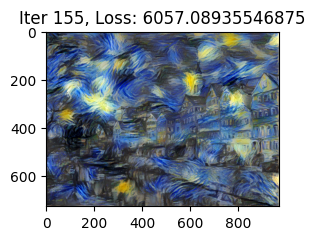

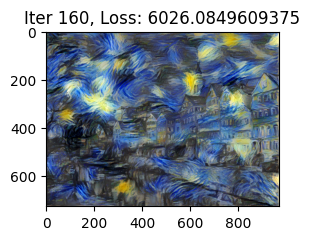

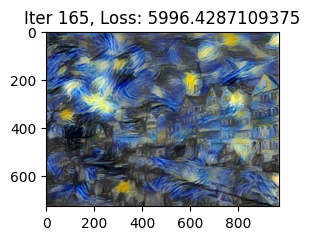

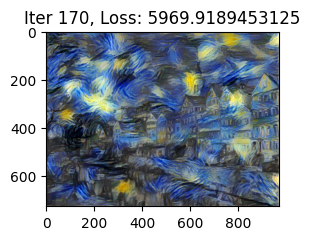

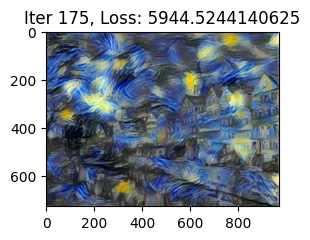

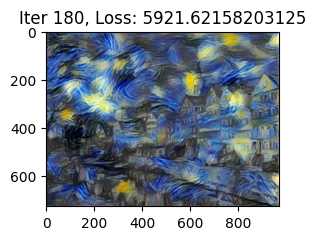

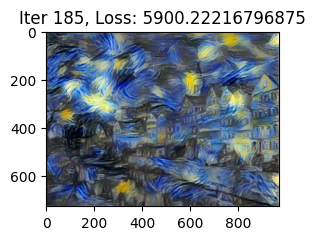

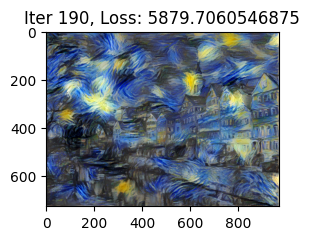

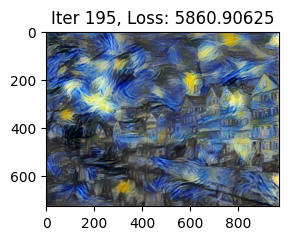

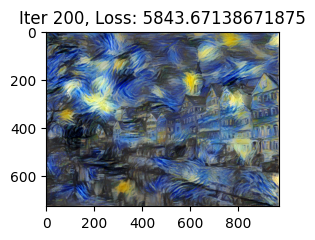

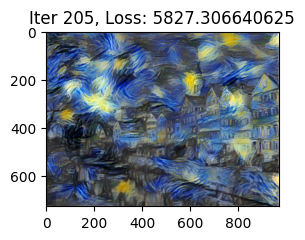

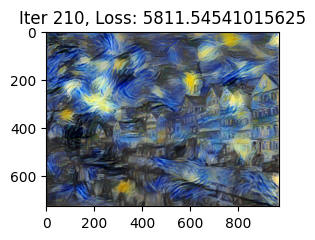

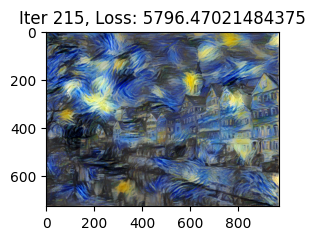

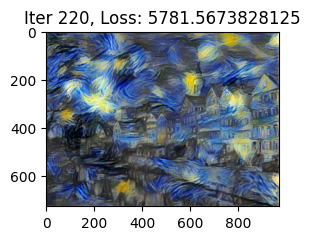

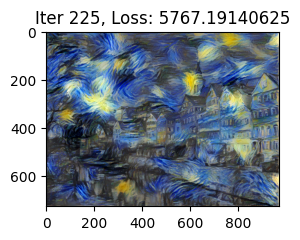

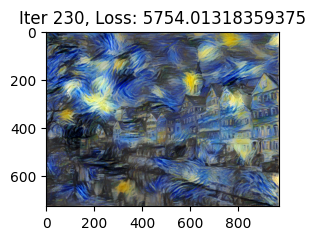

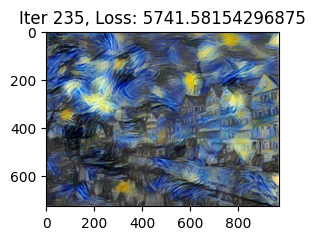

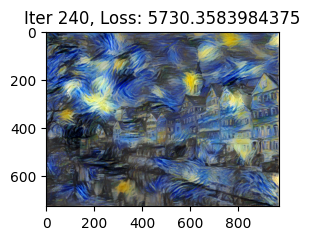

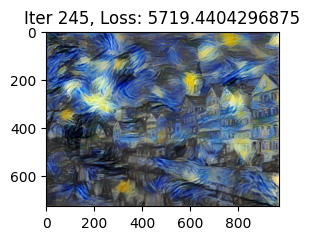

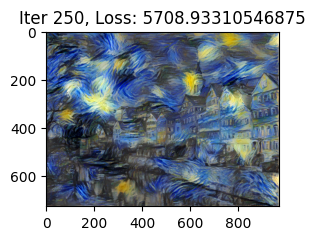

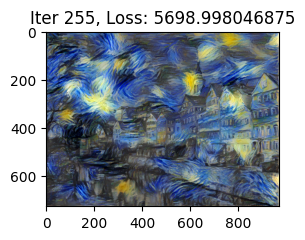

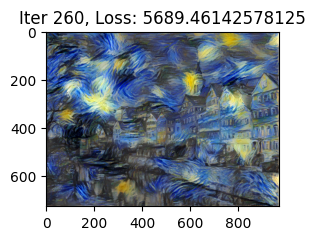

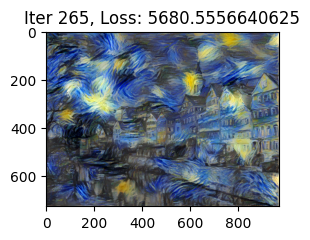

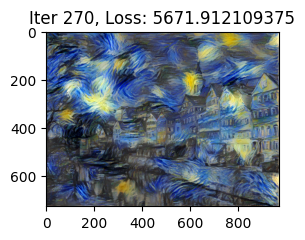

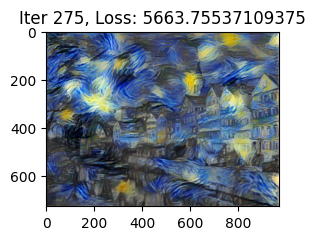

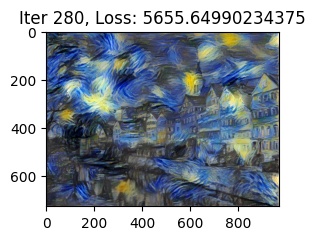

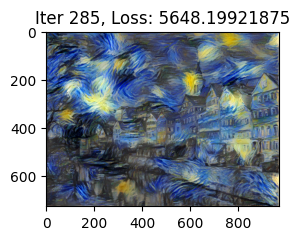

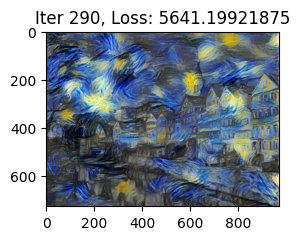

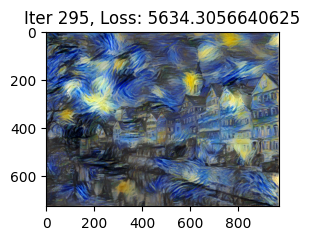

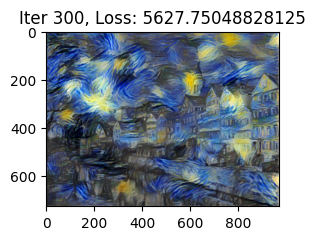

In [13]:
def closure():
    optimizer.zero_grad()
    target_features = get_features(target, model)
    target_content = target_features[21]
    target_styles = [target_features[i] for i in [0, 5, 10, 19, 28]]
    content_loss = F.mse_loss(target_content, content_feature) * content_weight
    style_loss = 0
    for target_style, style_gram, style_weight in zip(
            target_styles,
            style_grams,
            style_weights,
    ):
        target_gram = gram_matrix(target_style)
        style_loss += F.mse_loss(target_gram, style_gram) * style_weight
    total_loss = content_loss + style_loss
    total_loss.backward()
    return total_loss


for i in range(1, steps + 1):
    optimizer.step(closure)
    if i % show_every == 0:
        loss = closure()
        plt.figure(figsize=(3, 3))
        plt.imshow(post_process(target[0].cpu().detach()))
        plt.title(f"Iter {i}, Loss: {loss.item()}")
        plt.show()

保存结果

In [15]:
# save image
result = post_process(target[0].cpu().detach())
result.save(f"{save_path}{content_name}_{style_name}.jpg")